In [1]:
# %% [CELL 1] SETUP DAN IMPORT LIBRARY
# Pastikan library sudah terinstall: pip install ultralytics opencv-python matplotlib pyyaml

import json
import os
import shutil
import random
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ultralytics import YOLO

# --- KONFIGURASI UTAMA (USER SETTINGS) ---
# Ganti path ini sesuai lokasi dataset Anda
DATASET_ROOT = r"c:\Bisnis AI\Peta ATRBPN\PTNBPR-2" 

# Target kelas yang ingin dilatih (Urutan ini PENTING agar ID konsisten)
TARGET_CLASSES = [
    'asbestos_roof',       # ID 0
    'concrete_tile_roof',  # ID 1
    'metal_sheet_roof',    # ID 2
    'roof_temple_black'    # ID 3
]

# Konfigurasi Warna untuk Visualisasi (Format BGR untuk OpenCV)
# Merah, Kuning, Biru, Ungu
COLOR_MAP = {
    0: (0, 0, 255),    # asbestos -> Merah
    1: (0, 255, 255),  # concrete -> Kuning
    2: (255, 0, 0),    # metal    -> Biru
    3: (128, 0, 128)   # temple   -> Ungu
}

print(f"Setup Selesai. Root Folder: {DATASET_ROOT}")
print(f"Target Kelas: {TARGET_CLASSES}")

Setup Selesai. Root Folder: c:\Bisnis AI\Peta ATRBPN\PTNBPR-2
Target Kelas: ['asbestos_roof', 'concrete_tile_roof', 'metal_sheet_roof', 'roof_temple_black']


In [2]:
def prepare_dataset(root_path, target_classes):
    print("\n--- MULAI PERSIAPAN DATA ---")
    
    # 1. Bersihkan folder lama agar tidak duplikat
    for folder in ['valid', 'test']:
        p = os.path.join(root_path, folder)
        if os.path.exists(p):
            shutil.rmtree(p)
            print(f"Folder lama dihapus: {folder}")
            
    train_lbl_path = os.path.join(root_path, "train", "labels")
    if os.path.exists(train_lbl_path):
        shutil.rmtree(train_lbl_path)
        
    # 2. Baca JSON Anotasi
    json_path = os.path.join(root_path, "train", "_annotations.coco.json")
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"File JSON tidak ditemukan di: {json_path}")
        
    with open(json_path) as f:
        data = json.load(f)
        
    # 3. Buat Mapping ID (Filter kelas 'objects' dll)
    # Kita paksa ID sesuai urutan TARGET_CLASSES
    coco_id_to_yolo_id = {}
    for cat in data['categories']:
        if cat['name'] in target_classes:
            yolo_id = target_classes.index(cat['name'])
            coco_id_to_yolo_id[cat['id']] = yolo_id
            
    print(f"Mapping ID Kategori: {coco_id_to_yolo_id}")
    
    # 4. Konversi Anotasi ke .txt
    images_info = {img['id']: img for img in data['images']}
    os.makedirs(train_lbl_path, exist_ok=True)
    
    count_lbl = 0
    for ann in data['annotations']:
        if ann['category_id'] not in coco_id_to_yolo_id:
            continue # Skip jika bukan target class
            
        img_info = images_info.get(ann['image_id'])
        if not img_info: continue
        
        w, h = img_info['width'], img_info['height']
        cls_id = coco_id_to_yolo_id[ann['category_id']]
        
        # Ambil Segmentasi
        if 'segmentation' in ann and len(ann['segmentation']) > 0:
            for segment in ann['segmentation']:
                # Normalisasi koordinat
                norm_coords = []
                for i in range(0, len(segment), 2):
                    norm_coords.append(segment[i] / w)
                    norm_coords.append(segment[i+1] / h)
                
                label_line = f"{cls_id} " + " ".join(map(str, norm_coords)) + "\n"
                
                # Simpan txt
                fname = os.path.splitext(img_info['file_name'])[0]
                with open(os.path.join(train_lbl_path, f"{fname}.txt"), 'a') as f_out:
                    f_out.write(label_line)
            count_lbl += 1
            
    print(f"Berhasil mengonversi {count_lbl} poligon label.")
    
    # 5. Rapikan Gambar (Pindah ke folder images)
    train_img_path = os.path.join(root_path, "train", "images")
    os.makedirs(train_img_path, exist_ok=True)
    
    source_train = os.path.join(root_path, "train")
    # Pindahkan file gambar yang masih di root train ke train/images
    moved_img = 0
    for f in os.listdir(source_train):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            shutil.move(os.path.join(source_train, f), os.path.join(train_img_path, f))
            moved_img += 1
            
    # 6. Split Validation (20%)
    print("Membuat Split Validasi (20%)...")
    val_img_path = os.path.join(root_path, "valid", "images")
    val_lbl_path = os.path.join(root_path, "valid", "labels")
    os.makedirs(val_img_path, exist_ok=True)
    os.makedirs(val_lbl_path, exist_ok=True)
    
    all_imgs = [f for f in os.listdir(train_img_path) if f.endswith(('.jpg', '.png'))]
    num_val = int(len(all_imgs) * 0.2)
    val_files = random.sample(all_imgs, num_val)
    
    for f in val_files:
        # Move Image
        shutil.move(os.path.join(train_img_path, f), os.path.join(val_img_path, f))
        # Move Label
        txt_name = os.path.splitext(f)[0] + ".txt"
        src_txt = os.path.join(train_lbl_path, txt_name)
        if os.path.exists(src_txt):
            shutil.move(src_txt, os.path.join(val_lbl_path, txt_name))
            
    print(f"Total Train: {len(all_imgs) - num_val} images")
    print(f"Total Valid: {num_val} images")
    
    # 7. Buat file data.yaml
    yaml_data = {
        'path': root_path,
        'train': 'train/images',
        'val': 'valid/images',
        'nc': len(target_classes),
        'names': {i: name for i, name in enumerate(target_classes)}
    }
    
    yaml_path = os.path.join(root_path, "data_v2.yaml")
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_data, f)
        
    return yaml_path

# Jalankan Fungsi Persiapan
yaml_file = prepare_dataset(DATASET_ROOT, TARGET_CLASSES)
print(f"File Konfigurasi siap: {yaml_file}")


--- MULAI PERSIAPAN DATA ---
Folder lama dihapus: valid
Mapping ID Kategori: {1: 0, 2: 1, 3: 2, 4: 3}
Berhasil mengonversi 2675 poligon label.
Membuat Split Validasi (20%)...
Total Train: 26 images
Total Valid: 6 images
File Konfigurasi siap: c:\Bisnis AI\Peta ATRBPN\PTNBPR-2\data_v2.yaml


In [3]:
print("\n--- MULAI TRAINING ---")

# Best Practice Upgrades:
# 1. Model: Menggunakan 'yolov8s-seg.pt' (Small) -> Lebih akurat dari Nano, tapi masih ringan.
# 2. Imgsz: 1024 -> Agar genteng kecil terlihat jelas (High Res).
# 3. Augmentasi: FlipUD & Degrees -> Karena peta tidak punya atas/bawah, dan atap bisa miring.

model = YOLO('yolov8s-seg.pt') # Ganti ke 'yolov8m-seg.pt' jika PC Anda kuat

results = model.train(
    data=yaml_file,
    
    # Hyperparameters
    epochs=100,           # Beri waktu model belajar (akan stop jika patience trigged)
    patience=20,          # Early stopping
    batch=4,              # Kecilkan batch karena imgsz besar (cegah Out of Memory)
    imgsz=1024,           # Resolusi tinggi untuk Aerial Imagery
    
    # Aerial Augmentation
    degrees=15.0,         # Rotasi sedikit
    flipud=0.5,           # Atas-bawah (penting untuk peta)
    fliplr=0.5,           # Kiri-kanan
    mosaic=1.0,           # Bagus untuk objek kecil
    
    name='genteng_v2_best_practice',
    project='runs/segment',
    exist_ok=True
)

print(f"Training Selesai. Model tersimpan di: {results.save_dir}")


--- MULAI TRAINING ---
New https://pypi.org/project/ultralytics/8.4.13 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.10  Python-3.12.7 torch-2.10.0+cpu CPU (Intel Core i5-10400F 2.90GHz)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Bisnis AI\Peta ATRBPN\PTNBPR-2\data_v2.yaml, degrees=15.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, 


--- VISUALISASI HASIL ---

image 1/1 c:\Bisnis AI\Peta ATRBPN\PTNBPR-2\valid\images\14_jpeg.rf.428f8c027e157b90a9e56756be5c90d6.jpg: 416x1024 19 asbestos_roofs, 26 concrete_tile_roofs, 15 metal_sheet_roofs, 6 roof_temple_blacks, 217.9ms
Speed: 4.9ms preprocess, 217.9ms inference, 79.6ms postprocess per image at shape (1, 3, 416, 1024)


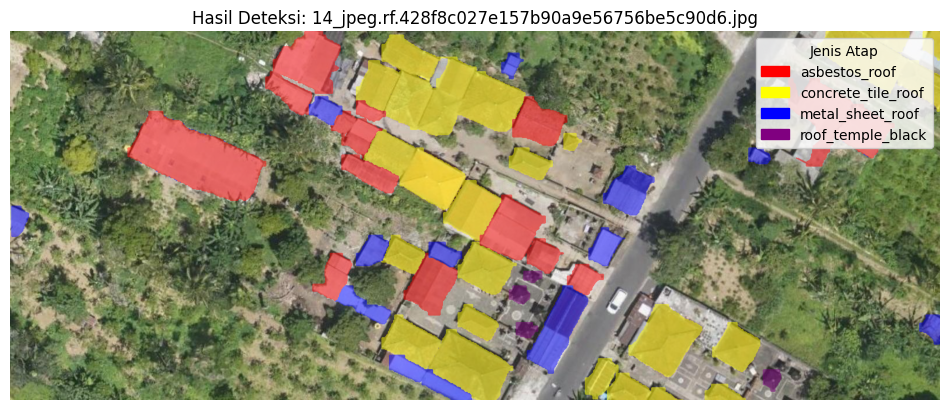


image 1/1 c:\Bisnis AI\Peta ATRBPN\PTNBPR-2\valid\images\35_jpeg.rf.7b113fe0a34d92f80e35d30f1fa7bea9.jpg: 544x1024 1 asbestos_roof, 10 concrete_tile_roofs, 20 metal_sheet_roofs, 7 roof_temple_blacks, 335.0ms
Speed: 6.1ms preprocess, 335.0ms inference, 60.5ms postprocess per image at shape (1, 3, 544, 1024)


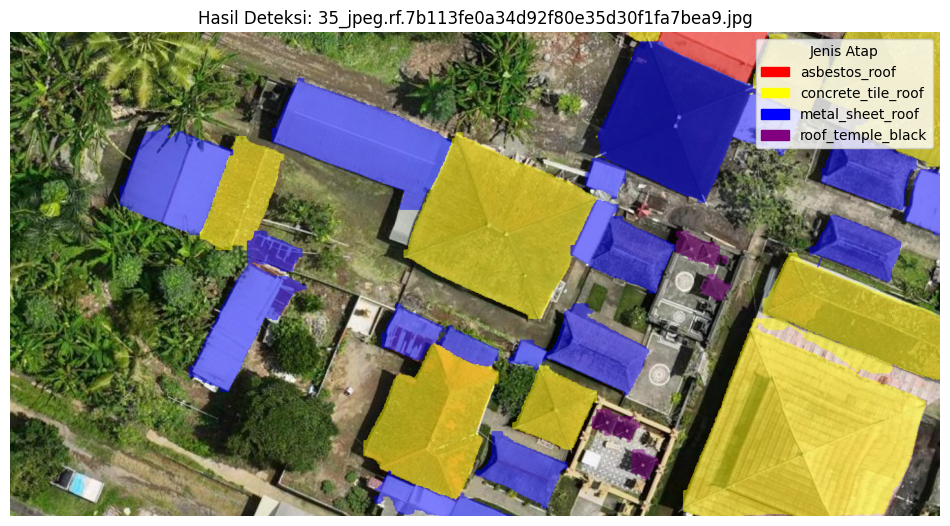


image 1/1 c:\Bisnis AI\Peta ATRBPN\PTNBPR-2\valid\images\40_jpeg.rf.2d39cbff12173a40b7acc6daab322820.jpg: 544x1024 4 asbestos_roofs, 16 concrete_tile_roofs, 23 metal_sheet_roofs, 1 roof_temple_black, 269.4ms
Speed: 5.2ms preprocess, 269.4ms inference, 82.7ms postprocess per image at shape (1, 3, 544, 1024)


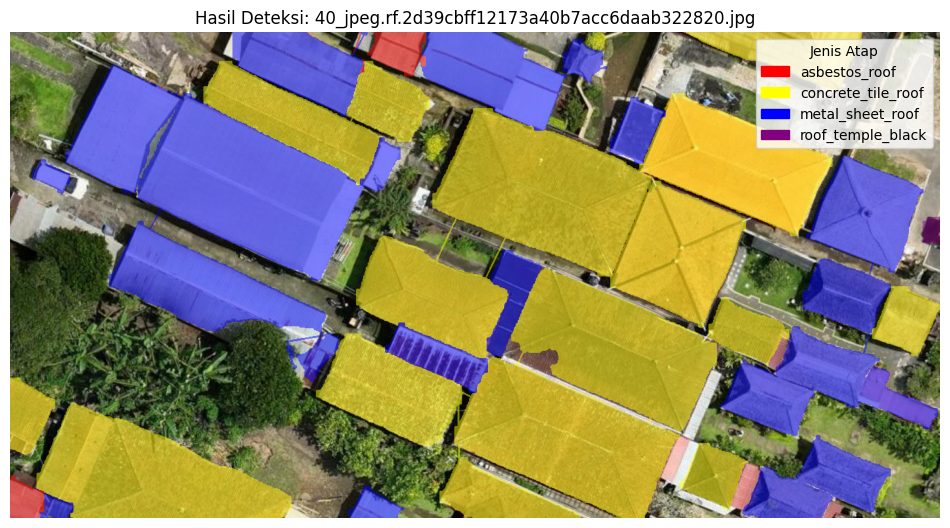


image 1/1 c:\Bisnis AI\Peta ATRBPN\PTNBPR-2\valid\images\46_jpeg.rf.3e87227cf7c9bc84c225420843a2896f.jpg: 544x1024 2 asbestos_roofs, 13 concrete_tile_roofs, 18 metal_sheet_roofs, 15 roof_temple_blacks, 328.3ms
Speed: 5.7ms preprocess, 328.3ms inference, 82.0ms postprocess per image at shape (1, 3, 544, 1024)


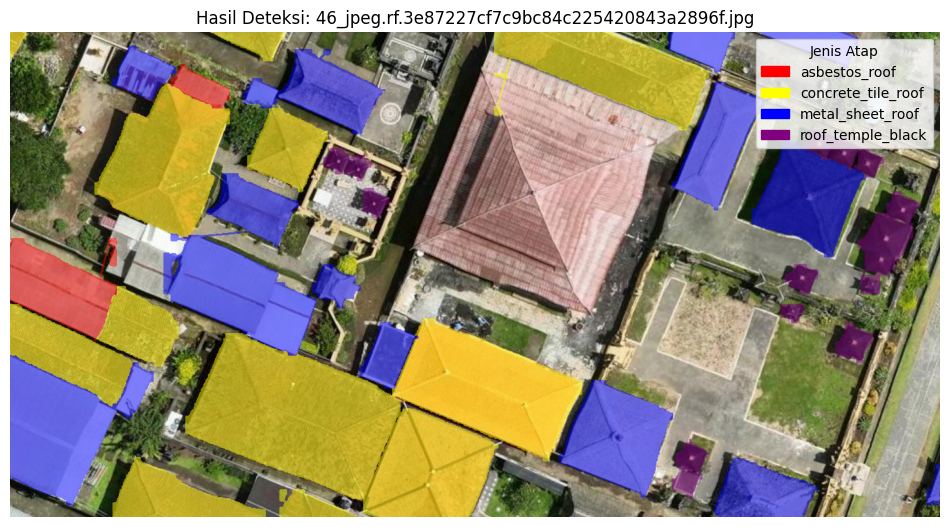


image 1/1 c:\Bisnis AI\Peta ATRBPN\PTNBPR-2\valid\images\7_jpeg.rf.f0894bd49540221e3ec41477ec3f8de4.jpg: 416x1024 15 asbestos_roofs, 49 concrete_tile_roofs, 18 metal_sheet_roofs, 25 roof_temple_blacks, 239.3ms
Speed: 4.4ms preprocess, 239.3ms inference, 134.0ms postprocess per image at shape (1, 3, 416, 1024)


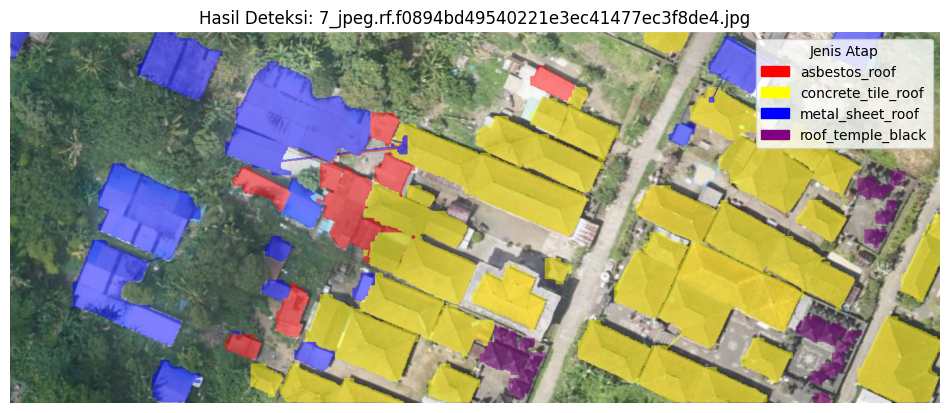

In [6]:
%matplotlib inline

def visualize_results(model_path, image_dir, num_samples=3):
    print("\n--- VISUALISASI HASIL ---")
    
    # Load Model Hasil Training
    best_model_path = os.path.join(model_path, "weights", "best.pt")
    if not os.path.exists(best_model_path):
        print("Model best.pt belum ada (mungkin training belum selesai). Pakai last.pt atau cek path.")
        return

    model = YOLO(best_model_path)
    files = os.listdir(image_dir)[:num_samples]
    
    # Mapping Nama Label untuk Legenda
    label_map = {i: name for i, name in enumerate(TARGET_CLASSES)}

    for f in files:
        img_path = os.path.join(image_dir, f)
        
        # Prediksi (imgsz disamakan dengan training agar akurat)
        results = model.predict(img_path, conf=0.25, imgsz=1024)
        
        img_original = cv2.imread(img_path)
        if img_original is None: continue
        
        overlay = img_original.copy()
        img_display = img_original.copy()
        
        detected_ids = set()
        
        for r in results:
            if r.masks is None: continue
            
            masks = r.masks.xy
            classes = r.boxes.cls.cpu().numpy().astype(int)
            
            for mask, cls_id in zip(masks, classes):
                detected_ids.add(cls_id)
                color = COLOR_MAP.get(cls_id, (255, 255, 255))
                
                # Gambar Masker Solid Manual
                pts = np.array(mask, np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(overlay, [pts], color)
                # Gambar Garis Pinggir
                cv2.polylines(overlay, [pts], True, color, 2)
                
        # Blend Gambar
        alpha = 0.5
        cv2.addWeighted(overlay, alpha, img_display, 1 - alpha, 0, img_display)
        
        # Buat Legenda Matplotlib
        legend_patches = []
        for cls_id in sorted(list(detected_ids)):
            # Convert BGR ke RGB (0-1)
            b, g, r_val = COLOR_MAP.get(cls_id, (200, 200, 200))
            color_rgb = (r_val/255.0, g/255.0, b/255.0)
            patch = mpatches.Patch(color=color_rgb, label=label_map[cls_id])
            legend_patches.append(patch)
            
        # Tampilkan
        img_final_rgb = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 12))
        plt.imshow(img_final_rgb)
        
        if legend_patches:
            plt.legend(handles=legend_patches, title="Jenis Atap", loc='upper right')
            
        plt.axis('off')
        plt.title(f"Hasil Deteksi: {f}")
        plt.show()

# Jalankan Visualisasi
# Pastikan path ini mengarah ke folder runs tempat training tadi disimpan
RUNS_PATH = r"runs/segment/runs/segment/genteng_v2_best_practice" 
VALID_DIR = os.path.join(DATASET_ROOT, "valid", "images")

visualize_results(RUNS_PATH, VALID_DIR, num_samples=5)